In [2]:
import time
import os, zipfile, requests, pandas as pd
import geopandas as gpd
import osmnx as ox, networkx as nx
import ast
import statistics
import numpy as np
from skopt import gp_minimize
from skopt.plots import plot_convergence
from sklearn.preprocessing import StandardScaler
#from sklearn.neighbors import BallTree
from shapely.geometry import Point
import random
from matplotlib import pyplot as plt
import matplotlib.path as mpltPath
import matplotlib.cm as cm
import matplotlib.colors as colors
import json 
from ast import literal_eval
import itertools
from collections import Counter
import descartes
import matplotlib
from shapely.geometry import LineString # To create line geometries that can be used in a GeoDataFrame
import math
import folium # To generate a Leaflet-based map of my data throughout my analysis
import branca.colormap as cm
import time
from time import gmtime, strftime
from selenium import webdriver
import imageio
import imgkit
import requests
import calendar
import seaborn as sns
import sys
sys.path.insert(1, '../google_data/baytraffic_share/credentials')
#from google_key import GOOGLE_MAPS_API_KEY
import scipy

from keplergl import KeplerGl 
from mapboxgl.utils import *
from mapboxgl.viz import *

# Load an empty map
from geopandas import GeoDataFrame # To create a GeoDataFrame from a DataFrame
from shapely.geometry import LineString # To create line geometries that can be used in a GeoDataFrame
pd.options.display.max_colwidth = 100

pd.set_option('display.max_rows', 4000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)



print('ox {}\nnx {}'.format(ox.__version__, nx.__version__))
start_time = time.time()

ox 0.10
nx 2.3


# Load the network (edges and nodes) and load the routes from the shortest path computation

In [2]:
def load_network(nodes_file, edges_file, path):
    nodes = pd.read_csv("{}/{}".format(path, nodes_file))
    edges = pd.read_csv("{}/{}".format(path, edges_file))
    return nodes, edges

In [3]:
#nodes, edges = load_network("nodes.csv", "edges.csv", "speeds_over_time_edge_vels")
#nodes, edges = load_network("nodes.csv", "edges.csv", "new_full_network")
nodes, edges = load_network("nodes.csv", "edges.csv", "../new_full_network_full_demand")
#nodes, edges = load_network("nodes.csv", "edges.csv", "speeds_tertiary")
#nodes, edges = load_network("nodes.csv", "edges.csv", "new_tertiary")
#nodes, edges = load_network("nodes.csv", "edges.csv", "full_network")

In [4]:
edges.head()

,uniqueid,u,v,length,lanes,speed_mph
0,0,4353687911,4353687912,10,1,25
1,1,4353687911,258755862,297,2,30
2,2,4353687912,65314933,103,2,30
3,3,4353687912,4353687911,10,1,25
4,4,4993566559,4993566530,55,2,20


In [5]:
def load_routes(routes_file, path):
    routes = pd.read_csv("{}/{}".format(path, routes_file), sep=':')
    return routes
    

In [6]:
#routes = load_routes("0_route_with_edges.csv", "../new_full_network_full_demand")
routes = load_routes("0_route5to12.csv", ".")

In [9]:
routes.head()

,p,route
0,0,"[544182,544181,383216,132131,542737,542660,542696,542743,542729,542733,542675,166353,158904,1589..."
1,1,"[158470,158467,163338,163335,542695,]"
2,2,"[165543,154679,154675,544179,544183,159139,13760,]"
3,3,"[158466,157687,158468,542676,542692,542684,542672,542714,542722,542735,542657,124221,124222,1242..."
4,4,"[164931,409211,157814,157817,163580,161378,161386,161389,152829,161391,163488,153891,163490,1634..."


In [11]:
x = routes[0:2]['route'].eval

AttributeError: 'Series' object has no attribute 'eval'

# Get the first and last edges for each route, and then merge them with their respective nodes

In [7]:
from ast import literal_eval

def vectorize_od_from_edge_routes(paths):
    new_df = pd.DataFrame()
    new_df['route'] = paths.route.apply(literal_eval)
    
    return new_df


def get_o_and_d_of_route(new_df):
    #od_list = []
    #new_df.loc[:, 'route'] = df.A.map(lambda x: x[0])
    newest_df = new_df.copy()
    newest_df['first'] = new_df.route.str[0]
    newest_df['last'] = new_df.route.str[-1]
    #newest_df['first'] = new_df.route.map(lambda row: row[0] if pd.isnan(new_df['route']) else new_df['route'])
    #newest_df['last'] = new_df.apply(lambda row: row['route'][len(row['route'])-1])
    #person_route_edge = pd.merge(new_df, edges[['uniqueid', 'u']], left_on='first', right_on='uniqueid', how='left')
    #person_route_edge_new = pd.merge(person_route_edge, edges[['uniqueid', 'v']], left_on='last', right_on='uniqueid', how='left')
    return newest_df



def get_nodes_of_first_and_last_edges(new_df, edges):
    person_route_edge = pd.merge(new_df, edges[['uniqueid', 'u', 'v']], left_on='first', right_on='uniqueid', how='left')
    print(person_route_edge.head())
    person_route_edge_new = pd.merge(person_route_edge, edges[['uniqueid', 'u', 'v']], left_on='last', right_on='uniqueid', how='left')
    
    return person_route_edge_new




In [8]:
eval_new_df = vectorize_od_from_edge_routes(routes)

In [12]:
eval_new_df.to_csv("all_routes_as_vectors.csv")

In [ ]:
eval_new_df = pd.read_csv("all_routes_as_vectors.csv")

In [78]:
eval_new_df.head()

,route
0,"[544182, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,..."
1,"[158470, 158467, 163338, 163335, 542695]"
2,"[165543, 154679, 154675, 544179, 544183, 159139, 13760]"
3,"[158466, 157687, 158468, 542676, 542692, 542684, 542672, 542714, 542722, 542735, 542657, 124221,..."
4,"[164931, 409211, 157814, 157817, 163580, 161378, 161386, 161389, 152829, 161391, 163488, 153891,..."


In [13]:
eval_new_df_first_and_last = get_o_and_d_of_route(eval_new_df)

In [14]:
eval_new_df_first_and_last.head()

,route,first,last
0,"[544182, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...",544182,158916
1,"[158470, 158467, 163338, 163335, 542695]",158470,542695
2,"[165543, 154679, 154675, 544179, 544183, 159139, 13760]",165543,13760
3,"[158466, 157687, 158468, 542676, 542692, 542684, 542672, 542714, 542722, 542735, 542657, 124221,...",158466,161632
4,"[164931, 409211, 157814, 157817, 163580, 161378, 161386, 161389, 152829, 161391, 163488, 153891,...",164931,163497


In [137]:
eval_new_df_first_and_last[(eval_new_df_first_and_last['first'] == 109986)\
                           & (eval_new_df_first_and_last['last'] == 296294)]

,route,first,last
14890,"[109986, 110026, 12864, 166968, 167366, 165954, 486614, 12798, 174343, 174622, 168177, 146754, 1...",109986,296294


In [15]:
nodes_of_first_and_last = get_nodes_of_first_and_last_edges(eval_new_df_first_and_last, edges)

                                                                                                 route  \
0  [544182, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...   
1                                                             [158470, 158467, 163338, 163335, 542695]   
2                                              [165543, 154679, 154675, 544179, 544183, 159139, 13760]   
3  [158466, 157687, 158468, 542676, 542692, 542684, 542672, 542714, 542722, 542735, 542657, 124221,...   
4  [164931, 409211, 157814, 157817, 163580, 161378, 161386, 161389, 152829, 161391, 163488, 153891,...   

   first   last  uniqueid          u          v  
0 544182 158916    544182 1723768799 1723768769  
1 158470 542695    158470   65305817   65305815  
2 165543  13760    165543   65327403   65295278  
3 158466 161632    158466   65305815   65303529  
4 164931 163497    164931   65325067  984720636  


In [16]:
nodes_of_first_and_last.head()

,route,first,last,uniqueid_x,u_x,v_x,uniqueid_y,u_y,v_y
0,"[544182, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...",544182,158916,544182,1723768799,1723768769,158916,65306817,65319536
1,"[158470, 158467, 163338, 163335, 542695]",158470,542695,158470,65305817,65305815,542695,1723739123,65334510
2,"[165543, 154679, 154675, 544179, 544183, 159139, 13760]",165543,13760,165543,65327403,65295278,13760,340164576,300759185
3,"[158466, 157687, 158468, 542676, 542692, 542684, 542672, 542714, 542722, 542735, 542657, 124221,...",158466,161632,158466,65305815,65303529,161632,65314241,265440514
4,"[164931, 409211, 157814, 157817, 163580, 161378, 161386, 161389, 152829, 161391, 163488, 153891,...",164931,163497,164931,65325067,984720636,163497,65320191,65313455


In [17]:

nodes_of_first_and_last[(nodes_of_first_and_last['first'] == 109986)\
                           & (nodes_of_first_and_last['last'] == 296294)]

,route,first,last,uniqueid_x,u_x,v_x,uniqueid_y,u_y,v_y
14890,"[109986, 110026, 12864, 166968, 167366, 165954, 486614, 12798, 174343, 174622, 168177, 146754, 1...",109986,296294,109986,295185114,295185200,296294,53027379,53027381


# Load the people output from MANTA and merge the people with their respective routes and their origin/destination nodes

In [3]:
#person_data = pd.read_csv("0_people5to12_without_time_logic.csv")
#person_data = pd.read_csv("0_people5to12_new_dists.csv")
person_data = pd.read_csv("0_people5to12_new_new_dists.csv")

In [6]:
person_data = person_data.dropna()

In [8]:
person_data.head()

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T,avg_v(mph)
0,0,1723768799,65319536,35570.5000,1281.0000,722.0340,949.4260,404.9510,1.0005,1.7995,1.8015,1.1923
1,1,65306804,65309526,28728.0000,67.0000,20.3629,82.7992,530.7040,1.2220,1.5524,1.0826,18.9315
2,2,1723738831,65313437,28983.8000,562.5000,217.7150,655.8540,3144.7500,1.4435,1.3058,1.5642,12.7320
3,3,65345319,719116877,27316.7000,226.5000,64.1847,227.7060,2213.1400,1.6660,1.0587,0.8452,19.8073
4,4,4019009287,989844836,33248.1000,599.5000,240.2820,718.9270,3186.1800,1.8875,1.8120,1.3263,12.2728


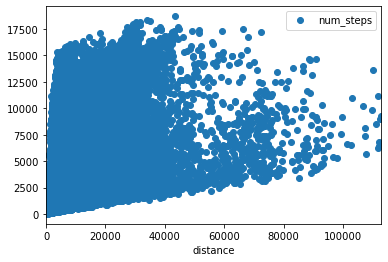

In [18]:
person_data[0:100000].plot(x = 'distance', y='num_steps', style='o')

In [131]:
def merge_people_with_routes(person_data, nodes_of_first_and_last):
    merged = pd.merge(person_data, nodes_of_first_and_last[['route', 'u_x', 'v_y', 'first', 'last']],\
                                     left_on=['init_intersection', 'end_intersection'],\
                                     right_on=['u_x', 'v_y'], how='left')
    
    return merged

In [132]:
people_routes_merged = merge_people_with_routes(person_data, nodes_of_first_and_last)

In [133]:
people_routes_merged.head()

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T,avg_v(mph),route,u_x,v_y,first,last
0,0,1723768799,65319536,35570.5000,1281.0000,722.0340,949.4260,404.9510,1.0005,1.7995,1.8015,1.1923,"[544182, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...",1723768799.0000,65319536.0000,544182.0000,158916.0000
1,1,65306804,65309526,28728.0000,67.0000,20.3629,82.7992,530.7040,1.2220,1.5524,1.0826,18.9315,"[158907, 162629, 162627, 156678, 162625, 162372, 151356, 162623, 162621, 26754, 26749, 26747, 15...",65306804.0000,65309526.0000,158907.0000,158888.0000
2,2,1723738831,65313437,28983.8000,562.5000,217.7150,655.8540,3144.7500,1.4435,1.3058,1.5642,12.7320,"[542660, 542695, 167451, 158899, 162619, 167453, 43128, 43024, 43120, 150857, 210243, 77275, 162...",1723738831.0000,65313437.0000,542660.0000,161378.0000
3,3,65345319,719116877,27316.7000,226.5000,64.1847,227.7060,2213.1400,1.6660,1.0587,0.8452,19.8073,NaN,nan,nan,nan,nan
4,4,4019009287,989844836,33248.1000,599.5000,240.2820,718.9270,3186.1800,1.8875,1.8120,1.3263,12.2728,"[27265, 542739, 159643, 158893, 26748, 152642, 165132, 164735, 161959, 161961, 161952, 77289, 77...",4019009287.0000,989844836.0000,27265.0000,41968.0000


In [134]:
people_routes_merged.shape[0]

3457823

In [135]:
people_routes_merged.dropna(inplace=True)

In [136]:
people_routes_merged.shape[0]

3068927

In [137]:
people_routes_merged.head()

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T,avg_v(mph),route,u_x,v_y,first,last
0,0,1723768799,65319536,35570.5000,1281.0000,722.0340,949.4260,404.9510,1.0005,1.7995,1.8015,1.1923,"[544182, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...",1723768799.0000,65319536.0000,544182.0000,158916.0000
1,1,65306804,65309526,28728.0000,67.0000,20.3629,82.7992,530.7040,1.2220,1.5524,1.0826,18.9315,"[158907, 162629, 162627, 156678, 162625, 162372, 151356, 162623, 162621, 26754, 26749, 26747, 15...",65306804.0000,65309526.0000,158907.0000,158888.0000
2,2,1723738831,65313437,28983.8000,562.5000,217.7150,655.8540,3144.7500,1.4435,1.3058,1.5642,12.7320,"[542660, 542695, 167451, 158899, 162619, 167453, 43128, 43024, 43120, 150857, 210243, 77275, 162...",1723738831.0000,65313437.0000,542660.0000,161378.0000
4,4,4019009287,989844836,33248.1000,599.5000,240.2820,718.9270,3186.1800,1.8875,1.8120,1.3263,12.2728,"[27265, 542739, 159643, 158893, 26748, 152642, 165132, 164735, 161959, 161961, 161952, 77289, 77...",4019009287.0000,989844836.0000,27265.0000,41968.0000
5,5,317122247,65306802,23557.3000,61.5000,17.5568,68.9234,500.1920,1.1090,1.5654,1.8079,19.9446,"[224632, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...",317122247.0000,65306802.0000,224632.0000,158904.0000


In [138]:
people_routes_merged['num_steps'] = people_routes_merged['num_steps'] / 60
people_routes_merged['distance'] = people_routes_merged['distance'] / 1000


In [139]:
people_routes_merged.head()

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T,avg_v(mph),route,u_x,v_y,first,last
0,0,1723768799,65319536,35570.5000,21.3500,722.0340,949.4260,0.4050,1.0005,1.7995,1.8015,1.1923,"[544182, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...",1723768799.0000,65319536.0000,544182.0000,158916.0000
1,1,65306804,65309526,28728.0000,1.1167,20.3629,82.7992,0.5307,1.2220,1.5524,1.0826,18.9315,"[158907, 162629, 162627, 156678, 162625, 162372, 151356, 162623, 162621, 26754, 26749, 26747, 15...",65306804.0000,65309526.0000,158907.0000,158888.0000
2,2,1723738831,65313437,28983.8000,9.3750,217.7150,655.8540,3.1448,1.4435,1.3058,1.5642,12.7320,"[542660, 542695, 167451, 158899, 162619, 167453, 43128, 43024, 43120, 150857, 210243, 77275, 162...",1723738831.0000,65313437.0000,542660.0000,161378.0000
4,4,4019009287,989844836,33248.1000,9.9917,240.2820,718.9270,3.1862,1.8875,1.8120,1.3263,12.2728,"[27265, 542739, 159643, 158893, 26748, 152642, 165132, 164735, 161959, 161961, 161952, 77289, 77...",4019009287.0000,989844836.0000,27265.0000,41968.0000
5,5,317122247,65306802,23557.3000,1.0250,17.5568,68.9234,0.5002,1.1090,1.5654,1.8079,19.9446,"[224632, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...",317122247.0000,65306802.0000,224632.0000,158904.0000


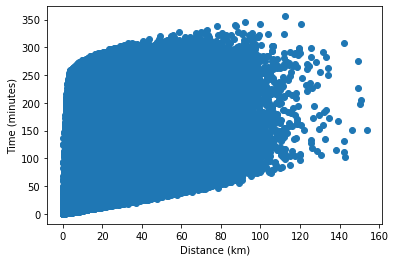

In [140]:
plt.scatter(people_routes_merged['distance'], people_routes_merged['num_steps'])

plt.xlabel('Distance (km)')
plt.ylabel('Time (minutes)')
plt.grid(False)

In [141]:
people_routes_merged[(people_routes_merged['first'] == 109986)\
                           & (people_routes_merged['last'] == 296294)]

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T,avg_v(mph),route,u_x,v_y,first,last
15393,14862,295185114,53027381,33715.6000,21.1917,443.9880,2357.1600,14.0782,1.8271,1.4422,0.8609,24.9445,"[109986, 110026, 12864, 166968, 167366, 165954, 486614, 12798, 174343, 174622, 168177, 146754, 1...",295185114.0000,53027381.0000,109986.0000,296294.0000


In [161]:
people_routes_merged[people_routes_merged.distance == 2.434]

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T,avg_v(mph),route,u_x,v_y,first,last
2302583,2292024,86276759,53057592,28905.6000,4.3500,74.6572,283.1650,2.4340,1.0173,1.2081,1.8134,20.1495,"[158258, 62876, 61724, 134372, 418576, 411156, 410263, 450913, 433143, 473453, 438154, 451409, 4...",86276759.0000,53057592.0000,158258.0000,344429.0000


In [142]:
#people_routes_merged_filtered = people_routes_merged[people_routes_merged['distance'] > 100]
people_routes_merged_filtered = people_routes_merged[people_routes_merged['distance'] < 5]
#people_routes_merged_filtered = people_routes_merged[people_routes_merged['num_steps'] > 300]

In [143]:
people_routes_merged_filtered.shape[0]

1326326

In [144]:
people_routes_merged[people_routes_merged['last'] == 542603]

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T,avg_v(mph),route,u_x,v_y,first,last
2041436,2032339,441520121,3632439894,27967.0000,9.7833,202.7180,663.7680,4.4647,1.2827,1.7248,1.3821,17.0856,"[34610, 34809, 23226, 34806, 326667, 32983, 126926, 15560, 15557, 7663, 297477, 297473, 297470, ...",441520121.0000,3632439894.0000,34610.0000,542603.0000
2057035,2047874,53020818,3632439894,29932.1000,10.6583,216.7690,766.7730,5.0083,1.4000,1.2527,1.5188,17.6170,"[290529, 314136, 314133, 314152, 317216, 289443, 289437, 289435, 289433, 289426, 289423, 289418,...",53020818.0000,3632439894.0000,290529.0000,542603.0000


In [145]:
people_routes_merged[people_routes_merged['p'] == 2047874]

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T,avg_v(mph),route,u_x,v_y,first,last
2057035,2047874,53020818,3632439894,29932.1000,10.6583,216.7690,766.7730,5.0083,1.4000,1.2527,1.5188,17.6170,"[290529, 314136, 314133, 314152, 317216, 289443, 289437, 289435, 289433, 289426, 289423, 289418,...",53020818.0000,3632439894.0000,290529.0000,542603.0000


In [146]:
people_routes_merged_filtered.head()

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T,avg_v(mph),route,u_x,v_y,first,last
0,0,1723768799,65319536,35570.5000,21.3500,722.0340,949.4260,0.4050,1.0005,1.7995,1.8015,1.1923,"[544182, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...",1723768799.0000,65319536.0000,544182.0000,158916.0000
1,1,65306804,65309526,28728.0000,1.1167,20.3629,82.7992,0.5307,1.2220,1.5524,1.0826,18.9315,"[158907, 162629, 162627, 156678, 162625, 162372, 151356, 162623, 162621, 26754, 26749, 26747, 15...",65306804.0000,65309526.0000,158907.0000,158888.0000
2,2,1723738831,65313437,28983.8000,9.3750,217.7150,655.8540,3.1448,1.4435,1.3058,1.5642,12.7320,"[542660, 542695, 167451, 158899, 162619, 167453, 43128, 43024, 43120, 150857, 210243, 77275, 162...",1723738831.0000,65313437.0000,542660.0000,161378.0000
4,4,4019009287,989844836,33248.1000,9.9917,240.2820,718.9270,3.1862,1.8875,1.8120,1.3263,12.2728,"[27265, 542739, 159643, 158893, 26748, 152642, 165132, 164735, 161959, 161961, 161952, 77289, 77...",4019009287.0000,989844836.0000,27265.0000,41968.0000
5,5,317122247,65306802,23557.3000,1.0250,17.5568,68.9234,0.5002,1.1090,1.5654,1.8079,19.9446,"[224632, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...",317122247.0000,65306802.0000,224632.0000,158904.0000


In [147]:
low_dist_high_time = people_routes_merged_filtered[people_routes_merged_filtered.num_steps > 60]

In [148]:
low_dist_high_time.shape[0]

167497

In [149]:
edges.head()

,uniqueid,u,v,length,lanes,speed_mph
0,0,4353687911,4353687912,9.9300,1,25
1,1,4353687911,258755862,297.4870,2,30
2,2,4353687912,65314933,103.2370,2,30
3,3,4353687912,4353687911,9.9300,1,25
4,4,4993566559,4993566530,54.7070,2,20


In [150]:
edges[edges.length == 106.7230]

,uniqueid,u,v,length,lanes,speed_mph
163338,163338,65319911,65319908,106.7230,3,30


In [151]:
low_dist_high_time.head()

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T,avg_v(mph),route,u_x,v_y,first,last
29,26,65319911,65319956,30224.0000,146.3833,4914.4000,7658.9300,3.8602,1.7676,1.3818,1.1137,1.4891,"[163337, 157685, 157686, 157689, 157691, 157694, 157699, 157701, 157702, 157704, 157707]",65319911.0000,65319956.0000,163337.0000,157707.0000
53,48,65319923,65321052,30967.7000,129.0917,4311.3500,6725.3500,3.7249,1.6478,1.9517,0.9012,1.5438,"[163339, 158466, 157687, 158468, 542675, 166353, 158904, 158906, 156687, 158907, 162628, 171415,...",65319923.0000,65321052.0000,163339.0000,159302.0000
70,65,65307368,65297547,30368.8000,145.1667,4906.4400,7014.3000,2.8094,1.4193,1.7556,1.8823,1.1277,"[159153, 159155, 157694, 157699, 157700, 161576, 165358, 162780, 165360, 165368, 174362, 542735,...",65307368.0000,65297547.0000,159153.0000,172290.0000
146,136,65306802,1723738887,32193.0000,183.4500,6241.3200,8370.7900,2.9748,1.1687,1.2309,1.2510,0.9487,"[158906, 156686, 156689, 542684]",65306802.0000,1723738887.0000,158906.0000,542684.0000
150,140,65303538,258912672,30029.1000,81.4167,2746.1300,3652.3900,2.4252,1.0562,1.2434,1.9757,1.3696,"[157691, 157694, 157699, 157700, 161576, 165358, 162780, 165360, 165368, 174362, 542735, 542657,...",65303538.0000,258912672.0000,157691.0000,157437.0000


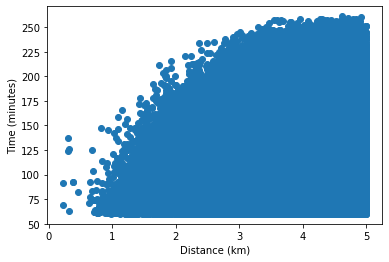

In [152]:
plt.scatter(low_dist_high_time['distance'], low_dist_high_time['num_steps'])

plt.xlabel('Distance (km)')
plt.ylabel('Time (minutes)')
plt.grid(False)

# Make a dataframe of a particular person's route (where each row is an edge of the route), and put into geometry linestring format with each edge's vertices, their OSM ids, and their lat/long. *The string format is for kepler.gl and QGIS*

In [177]:
def make_person_route_df(df):
    routes_list = df['route'].values.tolist()
    #print(routes_list)
    person_route_df = pd.DataFrame(routes_list[0], columns=['edge_id'])

    #print(eval(routes_list[person_index]))
    person_route_df['vol'] = 1 #add a volume column to df and make every value 1 for each edge in that person's route
    person_route_df.reset_index(inplace = True) 
    #all_routes_df.reset_index(inplace = True) 
    
    return person_route_df

In [178]:
def create_person_route_edge_with_geometry(person_route, edges, nodes, save=False, kepler_or_qgis=False):
    person_route_edge = pd.merge(person_route, edges[['uniqueid', 'u', 'v', 'length']], left_on='edge_id', right_on='uniqueid', how='left')
    person_route_edge_node1 = pd.merge(person_route_edge, nodes[['osmid', 'x', 'y']], left_on='u', right_on='osmid', how='left')
    person_route_edge_node1_node2 = pd.merge(person_route_edge_node1, nodes[['osmid', 'x', 'y']], left_on='v', right_on='osmid', how='left', suffixes=['_u', '_v'])

    df = person_route_edge_node1_node2

    if kepler_or_qgis:
        df['geometry'] = df.apply(lambda row: 'LINESTRING ({} {}, {} {})'.format(row['x_u'], row['y_u'], row['x_v'], row['y_v']), axis=1)
    else:
        df['geometry'] = df.apply(lambda row: LineString([(row['x_u'], row['y_u']), (row['x_v'], row['y_v'])]), axis=1)

    if save:
        df.to_csv('vis_route_{}.csv'.format(person_index), index=False)
    return df
    
    

In [162]:

#person_route = make_person_route_df(people_routes_merged_filtered[0:1])
#person_route = make_person_route_df(low_dist_high_time[1:2])
person_route = make_person_route_df(people_routes_merged[people_routes_merged['p'] == 2292024])
#person_route = make_person_route_df(people_routes_merged[0:1])
#person_route = make_person_route_df(people_routes_merged[(people_routes_merged['first'] == 109986)\
#                           & (people_routes_merged['last'] == 296294)])

geometry_string = create_person_route_edge_with_geometry(person_route, edges, nodes, save=False, kepler_or_qgis=True)


[[158258, 62876, 61724, 134372, 418576, 411156, 410263, 450913, 433143, 473453, 438154, 451409, 438732, 415882, 415885, 415887, 415890, 415893, 415895, 138746, 328972, 251702, 328977, 330588, 291493, 307981, 149286, 317130, 400510, 294010, 294012, 122329, 307498, 363065, 310418, 374094, 364394, 298108, 311779, 369962, 323367, 373136, 363269, 347406, 337353, 343867, 344429]]


In [163]:
geometry_string

,index,edge_id,vol,uniqueid,u,v,length,osmid_u,x_u,y_u,osmid_v,x_v,y_v,geometry
0,0,158258,1,158258,86276759,240487188,630.9550,86276759,-122.3087,37.8920,240487188,-122.3115,37.8971,"LINESTRING (-122.308673 37.8919759, -122.3115162 37.897127399999995)"
1,1,62876,1,62876,240487188,240477411,378.1350,240487188,-122.3115,37.8971,240477411,-122.3137,37.9000,"LINESTRING (-122.3115162 37.897127399999995, -122.3137206 37.9000473)"
2,2,61724,1,61724,240477411,240481105,168.2340,240477411,-122.3137,37.9000,240481105,-122.3120,37.9005,"LINESTRING (-122.3137206 37.9000473, -122.31195320000002 37.9005143)"
3,3,134372,1,134372,240481105,57815149,44.7810,240481105,-122.3120,37.9005,57815149,-122.3115,37.9007,"LINESTRING (-122.31195320000002 37.9005143, -122.3115063 37.9007087)"
4,4,418576,1,418576,57815149,57796266,29.7130,57815149,-122.3115,37.9007,57796266,-122.3112,37.9008,"LINESTRING (-122.3115063 37.9007087, -122.31120159999999 37.900825299999994)"
5,5,411156,1,411156,57796266,57789935,68.8440,57796266,-122.3112,37.9008,57789935,-122.3104,37.9010,"LINESTRING (-122.31120159999999 37.900825299999994, -122.3104436 37.9009826)"
6,6,410263,1,410263,57789935,57876904,53.6600,57789935,-122.3104,37.9010,57876904,-122.3098,37.9011,"LINESTRING (-122.3104436 37.9009826, -122.30984029999999 37.9010617)"
7,7,450913,1,450913,57876904,57841050,98.5510,57876904,-122.3098,37.9011,57841050,-122.3087,37.9012,"LINESTRING (-122.30984029999999 37.9010617, -122.308742 37.9012473)"
8,8,433143,1,433143,57841050,57939962,80.4260,57841050,-122.3087,37.9012,57939962,-122.3078,37.9014,"LINESTRING (-122.308742 37.9012473, -122.307845 37.90139620000001)"
9,9,473453,1,473453,57939962,57850099,46.8510,57939962,-122.3078,37.9014,57850099,-122.3073,37.9015,"LINESTRING (-122.307845 37.90139620000001, -122.3073223 37.9014823)"


In [164]:
map_2 = KeplerGl(height=1000, data={"data_1": geometry_string})
map_2

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(data={'data_1':     index  edge_id  vol  uniqueid           u           v   length  \
0       0   158…

In [165]:
geometry_string['length'].sum()

4665.460999999999

In [166]:
geometry_string.length.sum()

4665.460999999999

In [183]:
def get_correct_distances(person_data_merged, edges, nodes):
    real_dists = []
    for x in range(person_data_merged.shape[0]):
        person_route = make_person_route_df(person_data_merged.iloc[x:x+1])
        geometry_string = create_person_route_edge_with_geometry(person_route, edges, nodes, save=False, kepler_or_qgis=True)
        real_dist = geometry_string.length.sum()
        real_dists += [real_dist,]
    
    person_data_copy = person_data_merged.copy()
    person_data_copy['new_distance'] = np.array(real_dists) / 1000
    
    return person_data_copy
        
    

In [190]:

start_time = time.time()
person_data_copy = get_correct_distances(low_dist_high_time[0:1000], edges, nodes)
print("total time = {}".format(time.time() - start_time))

total time = 187.5331130027771


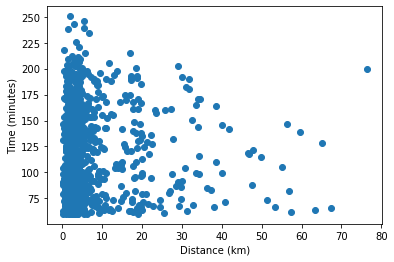

In [191]:
plt.scatter(person_data_copy['new_distance'], person_data_copy['num_steps'])

plt.xlabel('Distance (km)')
plt.ylabel('Time (minutes)')
plt.grid(False)

In [187]:
person_data_copy.head()

,p,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance,a,b,T,avg_v(mph),route,u_x,v_y,first,last,new_distance
0,0,1723768799,65319536,35570.5000,21.3500,722.0340,949.4260,0.4050,1.0005,1.7995,1.8015,1.1923,"[544182, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...",1723768799.0000,65319536.0000,544182.0000,158916.0000,2.4347
1,1,65306804,65309526,28728.0000,1.1167,20.3629,82.7992,0.5307,1.2220,1.5524,1.0826,18.9315,"[158907, 162629, 162627, 156678, 162625, 162372, 151356, 162623, 162621, 26754, 26749, 26747, 15...",65306804.0000,65309526.0000,158907.0000,158888.0000,1.8110
2,2,1723738831,65313437,28983.8000,9.3750,217.7150,655.8540,3.1448,1.4435,1.3058,1.5642,12.7320,"[542660, 542695, 167451, 158899, 162619, 167453, 43128, 43024, 43120, 150857, 210243, 77275, 162...",1723738831.0000,65313437.0000,542660.0000,161378.0000,3.9413
4,4,4019009287,989844836,33248.1000,9.9917,240.2820,718.9270,3.1862,1.8875,1.8120,1.3263,12.2728,"[27265, 542739, 159643, 158893, 26748, 152642, 165132, 164735, 161959, 161961, 161952, 77289, 77...",4019009287.0000,989844836.0000,27265.0000,41968.0000,18.6894
5,5,317122247,65306802,23557.3000,1.0250,17.5568,68.9234,0.5002,1.1090,1.5654,1.8079,19.9446,"[224632, 544181, 383216, 132131, 542737, 542660, 542696, 542743, 542729, 542733, 542675, 166353,...",317122247.0000,65306802.0000,224632.0000,158904.0000,1.2936


In [180]:
# start_time = time.time()
# person_data_copy = get_correct_distances(people_routes_merged, edges, nodes)
# print("total time = {}".format(time.time() - start_time))


### TOOK NEARLY 10 HOURS AND STILL NOT COMPLETE - NOT USEFUL

KeyboardInterrupt: 

In [192]:
edges.head()

,uniqueid,u,v,length,lanes,speed_mph
0,0,4353687911,4353687912,9.9300,1,25
1,1,4353687911,258755862,297.4870,2,30
2,2,4353687912,65314933,103.2370,2,30
3,3,4353687912,4353687911,9.9300,1,25
4,4,4993566559,4993566530,54.7070,2,20


In [193]:
edges[edges.duplicated(['u', 'v'])]

,uniqueid,u,v,length,lanes,speed_mph
187,187,4538245123,85948539,100.4830,1,20
498,498,369115602,369115602,51.7690,1,20
500,500,369115699,369115699,48.1270,1,20
520,520,369116100,369116100,46.2980,1,20
544,544,3586147901,3586147906,166.5730,1,20
548,548,3586147906,3586147901,166.5730,1,20
587,587,2491435918,65679582,115.4000,1,20
838,838,423650540,1832575802,854.5450,2,20
896,896,3548408563,667527951,636.5760,1,20
926,926,1459647112,1459647112,125.4930,1,20


In [194]:
547697 - 540827

6870